### 3. METHODOLOGIES
In order to find a feasible way to forecast the stock market,
we firstly made an assumption that the return of the target week may be somehow related the returns of a number of previous week.

Therefore, it is reasonable to come up with an idea that we could using the returns of a couple of weeks before the target week as the input,
and the return of the target week as output, to train a model regression model with one or high degrees,
in order to mine the information from the historical price data.

### 4. EXPERIMENT
#### 4.1 Data Exploration
We downloaded the full daily price history data of the 50 stocks on the stock ticker list using the yahoo finance API.
The data sheets for every stock have seven columns:
- Date: A string indicating the date
- Open: A floating point number indicates the price at the start of that trading day.
- High: A floating point number indicates the highest price at that trading day.
- Low: A floating point number indicates the lowest price at that trading day.
- Close: A floating point number indicates the price at the end of that trading day.
- Adj Close: A floating number calculated based on the closing price as well as some other factors such as dividend distribution.
- Volume: The amount of stocked traded.

Some stocks have a very long history, like IBM, started as early as 1960s,
while some stocks may have a very short history, such as DOW whose history started in 2019.
#### 4.2 Data Preprocessing
##### 4.2.1 Data Cleaning
In the downloaded data sometimes there are some zero entries, for example in DUK.csv there are zero values in Open:

In [9]:
import pandas as pd
df = pd.read_csv("data/raw/DUK.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,6.646331,6.428419,6.428419,0.898059,133540
1,1980-03-18,0.0,6.918722,6.428419,6.918722,0.966555,224861
2,1980-03-19,0.0,6.973200,6.700809,6.700809,0.936113,319394
3,1980-03-20,0.0,6.755288,6.646331,6.755288,0.943723,118855
4,1980-03-21,0.0,6.755288,6.646331,6.700809,0.936113,100270


We should remove the dates that contain zero values to ensure the data integrity for the following steps.

##### 4.2.2 Standardization and Refactor
The absolute prices have huge difference among different stocks or between different era in one stock.
Since we don't care of the absolute value of prices, but only the return of unit times,
we should convert the absolute prices into returns to standardize them.

$return_i = 100*\frac{close_{i+1}-close_{i}}{close_{i}}$

Then according to an adjustable argument LEN,
a number of continuous returns are put in one row along with their target week return as the inputs and outputs.
The head of AAPL.csv is shown as following:

In [11]:
import pandas as pd
df = pd.read_csv("data/preprocessed/AAPL.csv")
df.head()


,5_week_before,4_week_before,3_week_before,2_week_before,1_week_before,target
0,-1.739022,15.044093,5.000381,-6.593635,-2.744922,5.644789
1,15.044093,5.000381,-6.593635,-2.744922,5.644789,-13.740297
2,5.000381,-6.593635,-2.744922,5.644789,-13.740297,1.769800
3,-6.593635,-2.744922,5.644789,-13.740297,1.769800,-11.304417
4,-2.744922,5.644789,-13.740297,1.769800,-11.304417,-4.901660


#### 4.3 Test Correlation
If the returns of the previous weeks are had some correlation with the return of the target week,
it would be a strong proof for the effectiveness of this method.
The following is the calculated correlation coefficient between the target week return and the previous week returns,
and the plot of the correlation matrix.

5_week_before   -0.008124
4_week_before    0.002901
3_week_before   -0.019262
2_week_before    0.009432
1_week_before   -0.049536
target           1.000000
Name: target, dtype: float64


<AxesSubplot:>

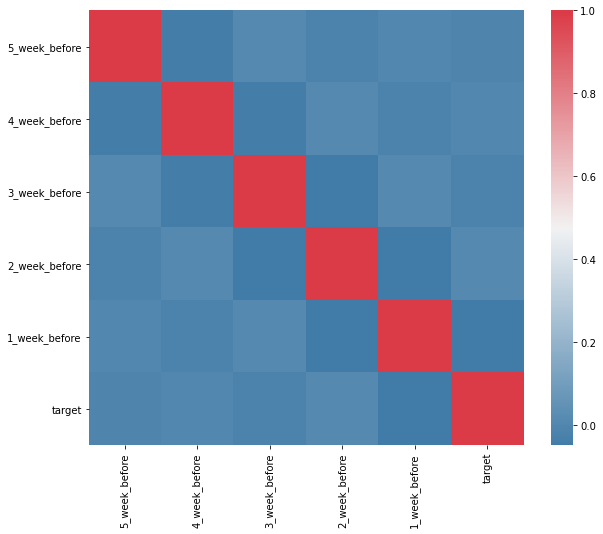

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns
from utils import PRE
dataframes = []
for path in os.listdir(PRE):
    df = pd.read_csv(PRE+path)
    dataframes.append(df)
total = pd.concat(dataframes)
f, ax = pl.subplots(figsize=(10, 8))
corr = total.corr()
print(corr['target'])
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

Although the absolute values of correlation coefficient are relatively small,
one important fact to notice is that the week closest to the target week has the biggest absolute value,
that is a strong indication for the effectiveness of the assumption.

#### 4.2 Training and Validation
We collect all the inputs and outputs from all the tickets, treat it as a single dataset,
and use a linear regression model to train it. The result is shown as following:

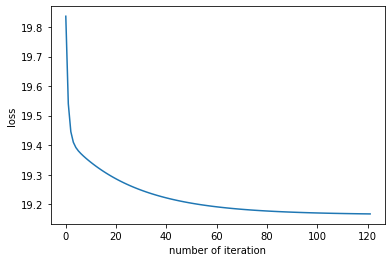

In [33]:
# create array
X = df.drop(columns=['target']).to_numpy()
X = np.c_[np.ones((X.shape[0], 1)), X]
Y = df['target'].to_numpy()
Y = np.reshape(Y, [Y.shape[0], 1])

from model_0 import BatchGradientDescent
model = BatchGradientDescent(X, Y, 0.01)
model.train()
model.plot_loss_history()

The loss of the prediction declined, and converged as the number of iteration increased.
Since the initial theta vector is set to contain only zero values,
this result demonstrated that knowing the returns of the previous weeks could be helpful,
theoretically, in predicting the stock market.

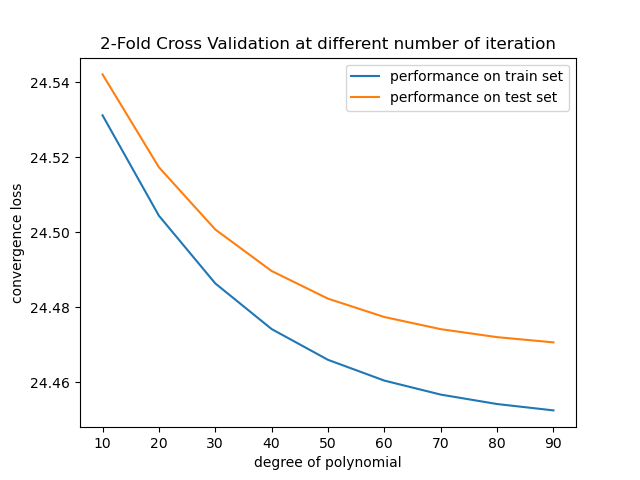

In [35]:
from IPython.display import Image
Image(filename = 'images/2-fold.png', width=1000, height=600)

And the validation using 2-fold method prove that although overfitting exist,
it doesn't cover all the effect of the model.

However, the absolute value changed very little actually,
and we believe that the most important reason for that is the intrinsic randomness of the market.


### 5. Suggestions for possible future work.
Data mining applied in stock market is a very interesting area.
In this experiment we only focused on using weekly returns,
however, there are several aspects that can be expanded in this research:
1. The time unit
We chose to use a week as a unit of time, but there are many other possible selection such as a month, a day,
   12, 8, 6, 4, 2 or 1 hour, that can be tested.
2. The type of data
We used the closing price of a unit period compare with the closing price with the previous period in this experiment,
   however, in more professional data analyzes there are other indexes that could be used,
   such as the highest price, the lowest price, the average price, the volume,
   or even some data beyond trading market,
   such as P/E ratio, P/B ratio or dividend rate which are related to the value of the stocks.